# <center> **Movie Review Classification - Transformer Encoder**</center>
<center>
    <img src = "https://repository-images.githubusercontent.com/399420811/c477ff5c-8d89-4f48-a038-3ef7d9f25e72">
         </img>
</center
    

### Installing Dependencies unavailable in the environment

In [61]:
!pip install contractions
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Download Necessary Packages

In [62]:
import os
from google.colab import files
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

import nltk
from collections import Counter
import contractions
import re
from nltk import sent_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences


### Setting Up Environment to get Kaggle Dataset in Colab

In [63]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                           Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          15598        453  1.0              
ruchi798/data-science-job-salaries                                 Data Science Job Salaries                             7KB  2022-06-15 08:59:12           4458        158  1.0              
zusmani/petrolgas-prices-worldwide                                 Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33           1935         91  1.0

In [64]:
!kaggle datasets download "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews"
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

 35% 9.00M/25.7M [00:00<00:00, 27.6MB/s]
100% 25.7M/25.7M [00:00<00:00, 64.4MB/s]
Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Set Constants to Maintain Consistensy over the notebook

In [65]:
np.random.RandomState(7)

title_fd = {
    'fontsize': 20,
    'font':'SERIF'
}
label_fd = {
    'fontsize': 10,
    'font': 'SERIF'
}

nltk.download("stopwords")
stopwords_ = stopwords.words('english')
print(stopwords_)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
# We create a custom list of stopwords
# We choose to keep words like not or other negating words, that might have important meaning to out text.
stopwords_ = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
              "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
              'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
              'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
              'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
              'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
              'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
              'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
              'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
              'most', 'other', 'some', 'such']
stopwords_pattern = re.compile(r'\b(' + r'|'.join(stopwords_) + r')\b\s*')

In [67]:
df = pd.read_csv('./IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [68]:
df.drop_duplicates(inplace = True, keep = 'first')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [70]:
df.describe(include = 'all')

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


Text(0.5, 1.0, 'Distribution of Sentiments in dataset')

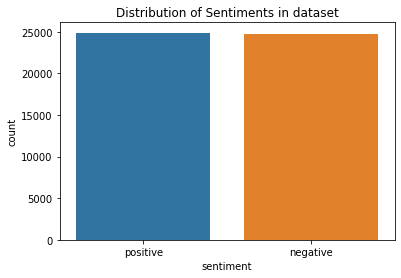

In [71]:
sns.countplot(data = df, x = 'sentiment')
plt.title('Distribution of Sentiments in dataset')

In [72]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [73]:
def preprocess_text(review):
    if isinstance(review, str):
        review = review.lower()
        review = contractions.fix(review)
        review = re.sub(r'<br />|\(|\)\{\}\[\]', " ", review)
        review = re.sub(r'[^A-Za-z]+',' ', review)
        review = stopwords_pattern.sub('', review)
    return review

In [75]:
df.review = df.review.apply(preprocess_text)

In [76]:
df.head()

,review,sentiment
0,one reviewers mentioned watching just oz episo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time too hot summe...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei s love time money visually stunn...,positive


In [77]:
df.review[0]

'one reviewers mentioned watching just oz episode will hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust not show faint hearted timid show pulls no punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards so privacy not high agenda city home many aryans muslims gangstas latinos christians italians irish so scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would not dare forget pretty pictures painted mainstream audiences forget charm forget romance oz not mess around first episode ever saw struck so nasty surreal could not say ready watched developed taste oz got accustomed high levels graphic violence not just violence injustice crooked guards will sold nickel inmates will kill order get away well man

## Convert Reviews into Vectors

In [78]:
def get_text_vectorizer(text_ds):
    text_vectorizer = TextVectorization()
    text_vectorizer.adapt(text_ds)
    vocab = text_vectorizer.get_vocabulary()
    word_index = dict(zip(vocab, range(len(vocab))))
    print("Total Number of Unique words in the text -", len(vocab))
    return vocab, word_index, text_vectorizer

In [79]:
vocab, word_index, text_vectorizer = get_text_vectorizer(df.review)

Total Number of Unique words in the text - 99230


In [80]:
vectorized_text = text_vectorizer(df.review)

In [81]:
print(vectorized_text.shape)
print("Max number of non-stop words in a review -", vectorized_text.shape[1])
print("Total Number of reviews - ", vectorized_text.shape[0])

(49582, 1472)
Max number of non-stop words in a review - 1472
Total Number of reviews -  49582


In [82]:
vectorized_text.shape[1]
max_words_in_review = vectorized_text.shape[1]

In [83]:
print(vectorized_text[0].numpy())

[   6 1946  933 ...    0    0    0]


In [84]:
print(vocab[:10])

['', '[UNK]', 'not', 'movie', 'film', 's', 'one', 'so', 'like', 'just']


In [85]:
# Word Index and vocabulary are basically inverse of each other
print(word_index['film'])

4


In [86]:
text__ = "My name is Aryan, and I am a Machine Learning enthusiast"
text__ = preprocess_text(text__)
text_vectorizer(text__)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([  283, 17201,  1369,  2693, 11227])>

    -> We can observe above, that the stopwords like ["my", "is", "and", "i", "am"..] are removed, and the vectorized text contains a list of integer indices
    

## Loading pre-trained Glove Embeddings

In [88]:
# Download the pretrained Glove Embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [89]:
# First, we see the format in which embedding vectors are present in the files
with open('./glove.6B.50d.txt', "r") as f:
    count = 0
    for line in f:
        if(count == 3):
            break
        print(line)
        print('\n')
        count += 1
    f.close()

In [90]:
def get_glove_emb_vectors(filepath):
    word_to_idx = {}
    idx_to_word = {}
    word_to_vec_map = {}
    
    with open(filepath, "r") as f:
        for idx, line in enumerate(f):
            word, vec = line.split(' ', maxsplit = 1)
            vec = np.fromstring(vec, dtype = np.float32, sep = " ")
            idx_to_word[idx] = word
            word_to_idx[word] = idx
            word_to_vec_map[word] = vec
    return word_to_idx, idx_to_word, word_to_vec_map

In [91]:
embedding_dims = 300
filepath = f'./glove.6B.{embedding_dims}d.txt'
word_to_idx, idx_to_word, word_to_vec = get_glove_emb_vectors(filepath)
print(f"Found {len(word_to_idx)} word vectors.")

In [92]:
# Let's look at the emb vector of a word
print(word_to_vec["hello"])

[-3.3712e-01 -2.1691e-01 -6.6365e-03 -4.1625e-01 -1.2555e+00 -2.8466e-02
 -7.2195e-01 -5.2887e-01  7.2085e-03  3.1997e-01  2.9425e-02 -1.3236e-02
  4.3511e-01  2.5716e-01  3.8995e-01 -1.1968e-01  1.5035e-01  4.4762e-01
  2.8407e-01  4.9339e-01  6.2826e-01  2.2888e-01 -4.0385e-01  2.7364e-02
  7.3679e-03  1.3995e-01  2.3346e-01  6.8122e-02  4.8422e-01 -1.9578e-02
 -5.4751e-01 -5.4983e-01 -3.4091e-02  8.0017e-03 -4.3065e-01 -1.8969e-02
 -8.5670e-02 -8.1123e-01 -2.1080e-01  3.7784e-01 -3.5046e-01  1.3684e-01
 -5.5661e-01  1.6835e-01 -2.2952e-01 -1.6184e-01  6.7345e-01 -4.6597e-01
 -3.1834e-02 -2.6037e-01 -1.7797e-01  1.9436e-02  1.0727e-01  6.6534e-01
 -3.4836e-01  4.7833e-02  1.6440e-01  1.4088e-01  1.9204e-01 -3.5009e-01
  2.6236e-01  1.7626e-01 -3.1367e-01  1.1709e-01  2.0378e-01  6.1775e-01
  4.9075e-01 -7.5210e-02 -1.1815e-01  1.8685e-01  4.0679e-01  2.8319e-01
 -1.6290e-01  3.8388e-02  4.3794e-01  8.8224e-02  5.9046e-01 -5.3515e-02
  3.8819e-02  1.8202e-01 -2.7599e-01  3.9474e-01 -2

In [93]:
# Now, we shall create the Embedding Matrix for our vocabulary

def get_embedding_matrix(word_index, word_to_vector):
    # Number of tokens in emb matrix is taken to be 2 more than vocab size
    hits, misses = 0, 0
    num_tokens = len(word_index) + 2
    
    # Use a common word expected to be in any embedding vector dictionary to get emb shape 
    emb_dims = word_to_vector['hello'].shape[0]
    
    # Initialize the embedding matrix with zeros
    embedding_matrix = np.zeros((num_tokens, emb_dims), dtype = np.float32)
    
    for word, idx in word_index.items():
        emb_vector = word_to_vector.get(word)
        if emb_vector is not None:
            embedding_matrix[idx] = emb_vector
            hits+= 1
        else:
            misses += 1
    print(f"For the {hits+misses} words in the vocabulary for given text,\n",
            f"{hits} words were found in the glove embeddings, while {misses} words could not be found")
    return embedding_matrix

In [94]:
EMBEDDING_MATRIX = get_embedding_matrix(word_index, word_to_vec)

In [95]:
EMBEDDING_MATRIX.shape

(99232, 300)

In [96]:
with open("Embedding_Matrix.npy", "wb") as f:
    np.save(f, EMBEDDING_MATRIX)
    f.close()

### Data Preparation

In [97]:
BATCH_SIZE = 128
MAX_SEQ_LEN = 1024
EMB_DIMS = 300
VOCAB_SIZE = EMBEDDING_MATRIX.shape[0]

In [98]:
def DataPipeline(df, text_vectorizer, truncating = 'post'):
    X_data = df.review.apply(preprocess_text)
    X_data = text_vectorizer(X_data)
    X_data = pad_sequences(X_data, maxlen = MAX_SEQ_LEN, truncating = truncating)
    Y_data = df.sentiment
    Y_data = df.sentiment.apply(lambda x: 1 if(x == 'positive') else 0)
    return X_data, Y_data
    

In [99]:
data = pd.read_csv('./IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [100]:
data.drop_duplicates(inplace = True)

In [101]:
data = data.sample(frac = 1, random_state = 7)
print(len(data))

49582


In [102]:
train = data[:30000]
validation = data[30000:40000]
test = data[40000:]

In [103]:
del(data)

In [104]:
train.head()

,review,sentiment
20275,I think that this is a disappointing sequel. I...,negative
19851,"Uhhh ... so, did they even have writers for th...",negative
6957,Critics are falling over themselves within the...,negative
30980,"This movie was very funny, I couldn't stop smi...",positive
40220,Happened upon a copy of this. Not mine and if ...,negative


In [105]:
X_train, Y_train = DataPipeline(train, text_vectorizer, truncating = 'post')
X_test, Y_test = DataPipeline(test, text_vectorizer,  truncating = 'post')
X_val, Y_val = DataPipeline(validation, text_vectorizer,  truncating = 'post')

In [106]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_val.shape, Y_val.shape)

(30000, 1024) (30000,)
(9582, 1024) (9582,)
(10000, 1024) (10000,)


In [107]:
with open("X_train.npy", "wb") as f:
    np.save(f, X_train)
    f.close()

with open("X_test.npy", "wb") as f:
    np.save(f, X_test)
    f.close()


with open("Y_train.npy", "wb") as f:
    np.save(f, Y_train)
    f.close()

with open("Y_test.npy", "wb") as f:
    np.save(f, Y_test)
    f.close()

with open("X_val.npy", "wb") as f:
    np.save(f, X_val)
    f.close()

with open("Y_val.npy", "wb") as f:
    np.save(f, Y_val)
    f.close()
        

<center> **a----------END-----------a** </center>